In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import xgboost
import lightgbm

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('train.csv')
df.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3.6_months_late,Count_6.12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
2,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
3,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1
4,1.000,24829,118400,0.0,0.0,0.0,99.05,11,B,Urban,7500,1


In [ ]:
X = df.drop('renewal', axis=1)
y = df['renewal']
y.value_counts()

1    49933
0     3303
Name: renewal, dtype: int64

In [ ]:
# X = X.fillna(-1)
X.isnull().sum()

perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3.6_months_late                 64
Count_6.12_months_late                64
Count_more_than_12_months_late        64
application_underwriting_score      1976
no_of_premiums_paid                    0
sourcing_channel                       0
residence_area_type                    0
premium                                0
dtype: int64

In [ ]:
LE = LabelEncoder()
for c in X.columns:
  if X[c].dtypes=='object':
    X[c] = LE.fit_transform(X[c])

In [ ]:
df_1 = df.sample(frac=1.0) # shuffle

In [ ]:
# df_train, df_test, df_valid = np.split(df.sample(frac=1.0), [int(0.7*len(df)), int(0.85*len(df))])
# print(df_train.shape, df_test.shape, df_valid.shape)

(37265, 12) (7985, 12) (7986, 12)


In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3) # 70 15 15
Xtest, Xvalid, Ytest, Yvalid = train_test_split(Xtest, Ytest, test_size=0.5)
print(Ytrain.shape, Ytest.shape, Yvalid.shape)

(37265,) (7985,) (7986,)


In [ ]:
import xgboost

XGB = xgboost.XGBClassifier(random_state=2020, n_estimators=2000, max_depth=8, colsample_bytree=0.85, missing=None,
                            scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=2.01, reg_lambda=0.05, verbosity=1)

XGB.fit(Xtrain, Ytrain, eval_set=[(Xtrain, Ytrain),(Xvalid, Yvalid)], verbose=2, early_stopping_rounds=10)
pred = XGB.predict(Xtest)
f1_score(Ytest, pred, pos_label=0)

[0]	validation_0-error:0.186717	validation_1-error:0.190458
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[2]	validation_0-error:0.15006	validation_1-error:0.155647
[4]	validation_0-error:0.137985	validation_1-error:0.144503
[6]	validation_0-error:0.13718	validation_1-error:0.142625
[8]	validation_0-error:0.126875	validation_1-error:0.132732
[10]	validation_0-error:0.130686	validation_1-error:0.136865
[12]	validation_0-error:0.129907	validation_1-error:0.135988
[14]	validation_0-error:0.129532	validation_1-error:0.135738
[16]	validation_0-error:0.130605	validation_1-error:0.137741
[18]	validation_0-error:0.130739	validation_1-error:0.135988
Stopping. Best iteration:
[8]	validation_0-error:0.126875	validation_1-error:0.132732



0.35790725326991674

In [ ]:
XGB = xgboost.XGBClassifier(random_state=2020, n_estimators=200, max_depth=8, colsample_bytree=0.85, missing=None,
                            scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=0.0, reg_lambda=0.0, verbosity=1)

ff = []
kf = KFold(n_splits=4)
for train_index, test_index in kf.split(X):
  
  Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
  Ytrain, Ytest = y[train_index], y[test_index]

  XGB.fit(Xtrain, Ytrain, eval_set=[(Xtrain, Ytrain),(Xtest, Ytest)], verbose=5, early_stopping_rounds=10)
  pred = XGB.predict(Xtest)
  ff.append(f1_score(Ytest, pred, pos_label=0))
ff.mean()

[0]	validation_0-error:0.159842	validation_1-error:0.173266
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[5]	validation_0-error:0.119969	validation_1-error:0.131114
[10]	validation_0-error:0.115661	validation_1-error:0.125855
[15]	validation_0-error:0.113883	validation_1-error:0.123676
Stopping. Best iteration:
[7]	validation_0-error:0.11253	validation_1-error:0.120745

[0]	validation_0-error:0.15894	validation_1-error:0.165001
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[5]	validation_0-error:0.130213	validation_1-error:0.137877
[10]	validation_0-error:0.120946	validation_1-error:0.129086
[15]	validation_0-error:0.121497	validation_1-error:0.131114
Stopping. Best iteration:
[8]	validation_0-error:0.117314	validation_1-error:0.124277

[0]	validation_0-error

[0.38168526356290877,
 0.38005997001499253,
 0.347007903650734,
 0.3434991974317817]

In [ ]:
import lightgbm

lgb = lightgbm.LGBMClassifier(random_state=2020, n_estimators=2000, num_leaves=31,
                              learning_rate=0.011, colsample_bytree=0.85, max_depth=-1,
                              verbose=1, class_weight={0:0.2, 1:0.8})
lgb.fit(Xtrain, Ytrain, eval_set=(Xvalid, Yvalid), verbose=100, early_stopping_rounds=50)
pred = lgb.predict(Xtest)
print(f1_score(Ytest, pred, pos_label=0))

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.220016
[200]	valid_0's binary_logloss: 0.214525
[300]	valid_0's binary_logloss: 0.213236
[400]	valid_0's binary_logloss: 0.212848
[500]	valid_0's binary_logloss: 0.212585
[600]	valid_0's binary_logloss: 0.212383
[700]	valid_0's binary_logloss: 0.212334
Early stopping, best iteration is:
[727]	valid_0's binary_logloss: 0.212313
0.0718562874251497


In [ ]:
lgb.best_iteration_

501

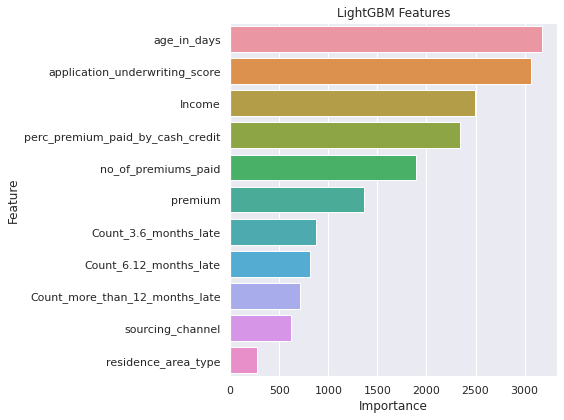

In [ ]:
imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':X.columns})
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data=imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
XGB = xgboost.XGBClassifier(random_state=2020, n_estimators=200, max_depth=8, colsample_bytree=0.85, missing=None, importance='gain',
                            scale_pos_weight=0.1, learning_rate=0.008, reg_alpha=0.0, reg_lambda=0.0, verbosity=1)
XGB.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0,
              importance='gain', learning_rate=0.008, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=None, n_estimators=200,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=2020, reg_alpha=0.0, reg_lambda=0.0,
              scale_pos_weight=0.1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [ ]:
imp = pd.DataFrame({'Importance':XGB.feature_importances_,'Feature':X.columns})
plt.figure(figsize=(8, 6))
sns.set(font_scale = 1)
sns.barplot(x="Importance", y="Feature", data=imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
!pip install catboost

     |████████████████████████████████| 64.4MB 60kB/s 


In [ ]:
from catboost import CatBoostClassifier
cat_features = ['sourcing_channel', 'residence_area_type']
model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=5, cat_features=cat_features)
model.fit(Xtrain, Ytrain, eval_set=(Xtest, Ytest), verbose=10, early_stopping_rounds=50)
pred = model.predict(Xtest)
f1_score(pred, Ytest, pos_label=0)

0:	learn: 0.5577112	total: 38.9ms	remaining: 7.74s
10:	learn: 0.2127082	total: 390ms	remaining: 6.71s
20:	learn: 0.1853554	total: 760ms	remaining: 6.47s
30:	learn: 0.1788380	total: 1.12s	remaining: 6.11s
40:	learn: 0.1767729	total: 1.48s	remaining: 5.75s
50:	learn: 0.1756472	total: 1.84s	remaining: 5.38s
60:	learn: 0.1748355	total: 2.22s	remaining: 5.07s
70:	learn: 0.1739057	total: 2.6s	remaining: 4.72s
80:	learn: 0.1732338	total: 2.98s	remaining: 4.38s
90:	learn: 0.1725535	total: 3.35s	remaining: 4.01s
100:	learn: 0.1719278	total: 3.72s	remaining: 3.64s
110:	learn: 0.1713583	total: 4.13s	remaining: 3.31s
120:	learn: 0.1707522	total: 4.5s	remaining: 2.94s
130:	learn: 0.1700818	total: 4.85s	remaining: 2.56s
140:	learn: 0.1696323	total: 5.21s	remaining: 2.18s
150:	learn: 0.1691463	total: 5.57s	remaining: 1.81s
160:	learn: 0.1687425	total: 5.92s	remaining: 1.43s
170:	learn: 0.1683256	total: 6.25s	remaining: 1.06s
180:	learn: 0.1681054	total: 6.57s	remaining: 690ms
190:	learn: 0.1676857	to

0.21479713603818615

In [ ]:
pred

array([0.97935197, 0.97487266, 0.97842644, ..., 0.954956  , 0.96662319,
       0.97466215])